In [1]:
from fastai.vision.all import *
from moving_mnist.models.conv_rnn import *
from moving_mnist.models.transformer import *
from moving_mnist.data import *

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print(torch.cuda.get_device_name())

Quadro RTX 8000


# Train Transformer Model:
> Based on DETR

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [3]:
Path.cwd()

Path('/home/tcapelle/SteadySun/moving_mnist')

In [4]:
DATA_PATH = Path.cwd()/'data'

In [5]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2], th=0.7)

In [6]:
train_tl = TfmdLists(range(300), ImageTupleTransform(ds, cl_type=TensorMask))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds, cl_type=TensorMask))

In [7]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=1,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

In [8]:
loss_func = StackLoss(CrossEntropyLossFlat(axis=2))

Left: Input, Right: Target

In [9]:
# dls.show_batch() #does not work for bs=1

## Baseline

`StackUnstack` takes cares of stacking the list of images into a fat tensor, and unstacking them at the end, we will need to modify our loss function to take a list of tensors as input and target.

In [10]:
# model = StackUnstack(DETR(resnet18, n_in=1, n_out=2, n=int(5*(64/32)**2), nheads=1, num_encoder_layers=1, num_decoder_layers=1))
model = StackUnstack(TransformerTS(n_in=1, n_out=2))

In [17]:
model

StackUnstack(
  (module): TransformerTS(
    (backbone): TimeDistributed(Encoder(
      (body): Sequential(
        (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=

As the `ImageSeq` is a `tuple` of images, we will need to stack them to compute loss.

In [18]:
learn = Learner(dls, model, loss_func=loss_func, splitter=partial(tf_split, stacked=True), cbs=[]).to_fp16()

In [19]:
learn.freeze()

I have a weird bug that if I use `nn.LeakyReLU` after doing `learn.lr_find()` the model does not train (the loss get stucked).

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.14454397559165955)

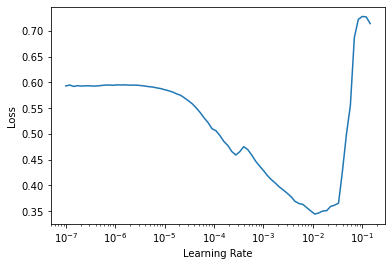

In [15]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss,time
0,0.129871,0.129139,00:28
1,0.125856,0.139628,00:28
2,0.130224,0.139459,00:29
3,0.123834,0.124233,00:28
4,0.128979,0.119502,00:28
5,0.116724,0.128846,00:28
6,0.113866,0.114182,00:28
7,0.115080,0.123263,00:28
8,0.119888,0.122002,00:28
9,0.112150,0.119879,00:29


In [21]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [22]:
len(p), p[0].shape

(5, torch.Size([100, 2, 64, 64]))

In [23]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

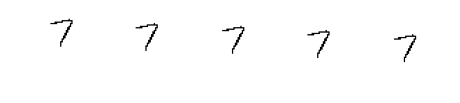

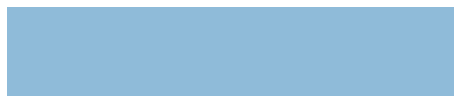

In [24]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k, True)

In [27]:
torch.__version__

'1.5.1'